In [48]:
%load_ext autoreload
%autoreload 2
    
from d3pm_sc.ct_sched_cond import SchdeuleCondition
from d3pm_sc.masking_diffusion import MaskingDiffusion
from d3pm_sc.d3pm_classic import D3PM_classic
from d3pm_sc.unet import UNet, SimpleUNet
from d3pm_sc.dit import DiT_Llama
from d3pm_sc import utils

import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import MNIST, CIFAR10
from torchvision.utils import make_grid
from tqdm import tqdm

from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
N = 128  # number of classes for discretized state per pixel
n_channel = 3
gamma = 0

s_dim = 4
conditional = True
forward_kwargs = {"type":"gaussian",
                  "normalized": False,
                  "bandwidth":1 / 7}

batch_size = 16
device = "cuda"
n_epoch = 14

# Schedule conditioning
# x0_model = DiT_Llama(n_channel, N, 50, True, s_dim=s_dim, dim=1024)
x0_model = SimpleUNet(n_channel, N, 500, True, s_dim=4)
model = SchdeuleCondition(x0_model, num_classes=N, hybrid_loss_coeff=0.01, gamma=gamma,
                          forward_kwargs=forward_kwargs, logistic_pars=True)
gen_trans_step = 200

# # Masking
# x0_model = SimpleUNet(n_channel, N+1, 50, False, s_dim=4)
# model = MaskingDiffusion(x0_model, num_classes=N, hybrid_loss_coeff=0.01).cuda()
# gen_trans_step = 50

if device == 'cuda':
    model = model.cuda()
print(f"Total Param Count: {sum([p.numel() for p in model.x0_model.parameters()])}")

# Load data
dataset = CIFAR10(
    "./data",
    train=True,
    download=True,
    transform=transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
)
def collate_fn(batch):
    x, cond = zip(*batch)
    x = torch.stack(x)
    cond = torch.tensor(cond)
    cond = (cond * conditional)
    x = (x * (N - 1)).round().long().clamp(0, N - 1)
    return x, cond
train_size = int(len(dataset) * 0.9)
dataset, test_dataset = random_split(dataset, [train_size, len(dataset) - train_size])
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=16, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=16, collate_fn=collate_fn)


Total Param Count: 1933712
Files already downloaded and verified


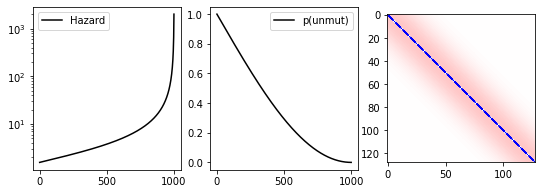

In [86]:
steps = torch.arange(1000 + 1, dtype=torch.float64) / 1000

fig, ax = plt.subplots(1, 3, figsize=[9, 3])
ax[0].semilogy(model.beta(steps), label="Hazard", color='black')
ax[0].legend()

alpha_bar = torch.exp(model.log_alpha(steps))
ax[1].plot(alpha_bar, label="p(unmut)", color='black')
ax[1].legend()

L = utils.get_inf_gens(forward_kwargs, N)
ax[2].imshow(L, vmin=-0.1, vmax=0.1, cmap='bwr')

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()

optim = torch.optim.AdamW(model.x0_model.parameters(), lr=1e-4)
model.train()

checkpoint_interval = 500

global_step = 0
for i in range(n_epoch):

    pbar = tqdm(dataloader, position=0, leave=True)
    loss_ema = None
    for x, cond in pbar:
        x, cond = x.to(device), cond.to(device)
        optim.zero_grad()
        loss, info = model(x, cond)
        loss.backward()

        #log
        norm = torch.nn.utils.clip_grad_norm_(model.x0_model.parameters(), 0.1)
        with torch.no_grad():
            param_norm = sum([torch.norm(p) for p in model.x0_model.parameters()])
        if loss_ema is None:
            loss_ema = loss.item()
        else:
            loss_ema = 0.99 * loss_ema + 0.01 * loss.item()
        pbar.set_description(
            f"loss: {loss_ema:.4f}, norm: {norm:.4f}, param_norm: {param_norm:.4f}, vb_loss: {info['vb_loss']:.4f}, ce_loss: {info['ce_loss']:.4f}"
        )
        optim.step()

        #print pics
        global_step += 1
        if global_step % checkpoint_interval == 0:
            model.eval()
            with torch.no_grad():
                utils.get_gif(x, model, gen_trans_step, N, 4, 
                              f"contents/sample_{global_step}.gif", f"contents/sample_{global_step}_last.png")
                
                val_loss = []
                k1_loss = []
                for x, cond in test_dataloader:
                    x, cond = x.to(device), cond.to(device)
                    
                    loss, info = model(x, cond)
                    val_loss.append(info['vb_loss'])
                    k1_loss.append(model.get_kl_t1(x).detach().item())
                bpd = (np.mean(val_loss) + np.mean(k1_loss)).round(4)
                print("val bits per dim:", bpd, ", perplexity:", np.exp(bpd).round(4),
                      "k1 loss:", np.mean(k1_loss).round(4))

            model.train()

loss: 6.1786, norm: 0.9838, param_norm: 177.2231, vb_loss: 5.4009, ce_loss: 5.3690:   0%|   | 1/2813 [00:00<30:21,  1.54it/s]

max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.6094e-05, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-12.2167, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.3554, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.1983e-05, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-12.3589, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.3473, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.2813e-05, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-12.0506, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.3678, device='cuda:0', grad_fn=<MaxBackward1>)


loss: 6.1621, norm: 1.0325, param_norm: 177.2371, vb_loss: 5.3646, ce_loss: 5.7016:   0%|   | 5/2813 [00:00<07:11,  6.51it/s]

max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.0146e-05, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-12.4160, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.3422, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.4698e-05, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-12.6282, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.3265, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.1579e-05, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-12.7854, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.3154, device='cuda:0', grad_fn=<MaxBackward1>)


loss: 6.1429, norm: 0.7090, param_norm: 177.2501, vb_loss: 5.2112, ce_loss: 5.1261:   0%|   | 7/2813 [00:01<05:41,  8.22it/s]

max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.6731e-05, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-12.5247, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.3341, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.1387e-05, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-12.7854, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.3144, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-5.1393e-06, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.1698, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.2765, device='cuda:0', grad_fn=<MaxBackward1>)


loss: 6.1348, norm: 0.6334, param_norm: 177.2628, vb_loss: 6.3261, ce_loss: 5.8077:   0%|  | 11/2813 [00:01<04:30, 10.37it/s]

max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.3338e-05, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-12.6653, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.3219, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.7037e-06, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.3033, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.2616, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-7.3942e-06, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.0246, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.2934, device='cuda:0', grad_fn=<MaxBackward1>)


loss: 6.1253, norm: 0.8100, param_norm: 177.2754, vb_loss: 5.4491, ce_loss: 5.4743:   0%|  | 13/2813 [00:01<04:12, 11.08it/s]

max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-9.4022e-06, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-12.8743, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.3052, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-9.1505e-06, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-12.9220, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.3042, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.5798e-05, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-12.5751, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.3305, device='cuda:0', grad_fn=<MaxBackward1>)


loss: 6.1002, norm: 1.3201, param_norm: 177.2878, vb_loss: 5.0929, ce_loss: 5.2034:   1%|  | 17/2813 [00:01<03:54, 11.92it/s]

max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-4.3359e-06, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.2682, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.2697, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.0001e-05, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-12.8514, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.3078, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.9867e-05, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-12.4160, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.3415, device='cuda:0', grad_fn=<MaxBackward1>)


loss: 6.0924, norm: 0.9018, param_norm: 177.2995, vb_loss: 6.0373, ce_loss: 5.5657:   1%|  | 19/2813 [00:02<03:51, 12.07it/s]

max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.6991e-05, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-12.5247, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.3347, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.3959e-05, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-12.6466, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.3240, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.0836e-05, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-12.8069, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.3117, device='cuda:0', grad_fn=<MaxBackward1>)


loss: 6.0618, norm: 0.6642, param_norm: 177.3119, vb_loss: 4.1960, ce_loss: 5.0897:   1%|  | 23/2813 [00:02<03:45, 12.36it/s]

max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.5257e-05, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-12.5925, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.3285, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-7.1070e-06, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.0520, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.2916, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.4533e-05, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-12.6282, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.3259, device='cuda:0', grad_fn=<MaxBackward1>)


loss: 6.0349, norm: 1.5408, param_norm: 177.3237, vb_loss: 4.7387, ce_loss: 5.2759:   1%|  | 25/2813 [00:02<03:43, 12.46it/s]

max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.3220e-05, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-12.7037, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.3216, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.0932e-05, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-12.8069, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.3122, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.1432e-05, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-12.3589, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.3457, device='cuda:0', grad_fn=<MaxBackward1>)


loss: 6.0202, norm: 1.0368, param_norm: 177.3347, vb_loss: 5.2119, ce_loss: 5.2888:   1%|  | 29/2813 [00:02<03:41, 12.58it/s]

max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.7688e-05, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-12.5084, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.3362, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.5360e-05, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-12.5925, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.3289, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-8.2963e-06, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-12.9720, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.2994, device='cuda:0', grad_fn=<MaxBackward1>)


loss: 6.0032, norm: 0.7659, param_norm: 177.3451, vb_loss: 5.2932, ce_loss: 5.3518:   1%|  | 31/2813 [00:03<03:40, 12.63it/s]

max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-9.2411e-06, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-12.9220, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.3046, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-8.3182e-06, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-12.9467, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.2996, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-4.7109e-06, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.2343, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.2732, device='cuda:0', grad_fn=<MaxBackward1>)


loss: 5.9794, norm: 0.8397, param_norm: 177.3550, vb_loss: 4.7604, ce_loss: 5.2838:   1%|  | 35/2813 [00:03<03:40, 12.63it/s]

max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.2991e-06, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.5000, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.2414, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.8572e-06, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.4167, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.2504, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.9129e-06, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.3033, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.2642, device='cuda:0', grad_fn=<MaxBackward1>)


loss: 5.9520, norm: 0.7384, param_norm: 177.3647, vb_loss: 4.6222, ce_loss: 5.3362:   1%|  | 37/2813 [00:03<03:39, 12.64it/s]

max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.0108e-06, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.5910, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.2067, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-9.3026e-07, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.6911, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.2024, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.2557e-06, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.5910, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.2147, device='cuda:0', grad_fn=<MaxBackward1>)


loss: 5.9400, norm: 0.9663, param_norm: 177.3740, vb_loss: 5.2965, ce_loss: 5.5520:   1%|  | 41/2813 [00:03<03:39, 12.65it/s]

max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.7899e-06, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.5445, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.2297, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-7.8421e-07, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.6911, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.1956, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-6.8351e-07, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.6911, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.1906, device='cuda:0', grad_fn=<MaxBackward1>)


loss: 5.9112, norm: 1.2932, param_norm: 177.3831, vb_loss: 4.5616, ce_loss: 5.1846:   2%|  | 43/2813 [00:04<03:39, 12.64it/s]

max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.1033e-06, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.5910, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.2101, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.2355e-06, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.5910, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.2140, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-7.0854e-07, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.6911, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.1926, device='cuda:0', grad_fn=<MaxBackward1>)


loss: 5.8999, norm: 1.2038, param_norm: 177.3922, vb_loss: 4.9578, ce_loss: 5.4251:   2%|  | 47/2813 [00:04<03:38, 12.64it/s]

max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-6.6981e-07, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.6911, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.1895, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.1359e-07, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.1600, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.3576e-07, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.1283, device='cuda:0', grad_fn=<MaxBackward1>)


loss: 5.8816, norm: 1.7149, param_norm: 177.4012, vb_loss: 5.3298, ce_loss: 5.4116:   2%|  | 49/2813 [00:04<03:38, 12.62it/s]

max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.5477e-08, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.0800, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-4.8342e-08, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.0898, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-5.1358e-08, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.0921, device='cuda:0', grad_fn=<MaxBackward1>)


loss: 5.8519, norm: 1.2191, param_norm: 177.4100, vb_loss: 4.8569, ce_loss: 5.4275:   2%|  | 53/2813 [00:04<03:38, 12.65it/s]

max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.8000e-08, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.0834, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-7.2900e-07, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.6911, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.1936, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.4589e-07, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.1496, device='cuda:0', grad_fn=<MaxBackward1>)


loss: 5.8382, norm: 0.8847, param_norm: 177.4193, vb_loss: 4.5807, ce_loss: 4.8941:   2%|  | 55/2813 [00:05<03:37, 12.66it/s]

max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-5.2312e-08, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.0929, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.1158e-07, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.1452, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.5569e-07, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.1509, device='cuda:0', grad_fn=<MaxBackward1>)


loss: 5.8096, norm: 0.9922, param_norm: 177.4288, vb_loss: 4.4142, ce_loss: 5.3334:   2%|  | 59/2813 [00:05<03:37, 12.65it/s]

max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.3353e-08, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.0663, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-4.1717e-08, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.0853, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-5.9388e-08, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.0990, device='cuda:0', grad_fn=<MaxBackward1>)


loss: 5.7841, norm: 1.5401, param_norm: 177.4380, vb_loss: 4.5478, ce_loss: 5.0300:   2%|  | 61/2813 [00:05<03:37, 12.64it/s]

max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.7276e-07, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.1360, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.1699e-07, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.1215, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.3120e-07, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.1265, device='cuda:0', grad_fn=<MaxBackward1>)


loss: 5.7604, norm: 1.2356, param_norm: 177.4468, vb_loss: 4.4797, ce_loss: 5.1859:   2%|  | 65/2813 [00:05<03:38, 12.60it/s]

max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-9.3431e-08, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.1150, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.5396e-07, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.1507, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.5340e-07, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.1323, device='cuda:0', grad_fn=<MaxBackward1>)


loss: 5.7450, norm: 1.2373, param_norm: 177.4560, vb_loss: 5.5873, ce_loss: 5.3590:   2%|  | 67/2813 [00:05<03:37, 12.62it/s]

max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-6.2683e-08, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.1001, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.7588e-07, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.1659, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.9171e-07, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.1403, device='cuda:0', grad_fn=<MaxBackward1>)


loss: 5.7164, norm: 1.5907, param_norm: 177.4648, vb_loss: 5.1366, ce_loss: 5.2350:   3%|  | 71/2813 [00:06<03:37, 12.63it/s]

max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-8.5579e-08, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.1110, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.8138e-07, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.1547, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.6997e-07, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.1354, device='cuda:0', grad_fn=<MaxBackward1>)


loss: 5.7069, norm: 1.3015, param_norm: 177.4737, vb_loss: 5.3300, ce_loss: 5.3683:   3%|  | 73/2813 [00:06<03:36, 12.64it/s]

max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.4803e-07, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.1314, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.1728e-07, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.1463, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-8.2705e-08, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.1094, device='cuda:0', grad_fn=<MaxBackward1>)


loss: 5.6914, norm: 1.8687, param_norm: 177.4830, vb_loss: 5.0408, ce_loss: 5.2658:   3%|  | 77/2813 [00:06<03:36, 12.64it/s]

max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-4.9442e-08, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.0906, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.1129e-08, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.0401, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.2321e-09, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.0018, device='cuda:0', grad_fn=<MaxBackward1>)


loss: 5.6763, norm: 1.0468, param_norm: 177.4921, vb_loss: 4.9680, ce_loss: 5.2619:   3%|  | 79/2813 [00:06<03:36, 12.64it/s]

max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-5.1471e-08, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.0922, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-5.7497e-08, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.0973, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-6.1225e-09, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.0219, device='cuda:0', grad_fn=<MaxBackward1>)


loss: 5.6543, norm: 1.3050, param_norm: 177.5016, vb_loss: 4.5424, ce_loss: 5.0230:   3%|  | 83/2813 [00:07<03:36, 12.62it/s]

max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.5503e-09, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.9781, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.0078e-08, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.0377, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-6.0992e-10, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.9510, device='cuda:0', grad_fn=<MaxBackward1>)


loss: 5.6510, norm: 1.5842, param_norm: 177.5110, vb_loss: 5.3504, ce_loss: 5.2186:   3%|  | 85/2813 [00:07<03:36, 12.63it/s]

max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.0614e-09, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.9673, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.8888e-09, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.9851, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.1931e-10, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.9058, device='cuda:0', grad_fn=<MaxBackward1>)


loss: 5.6321, norm: 2.9552, param_norm: 177.5204, vb_loss: 4.6312, ce_loss: 4.8642:   3%|  | 89/2813 [00:07<03:35, 12.63it/s]

max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.6302e-09, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.9796, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.9642e-11, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.8681, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.1414e-10, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.9042, device='cuda:0', grad_fn=<MaxBackward1>)


loss: 5.6165, norm: 1.5221, param_norm: 177.5300, vb_loss: 4.5222, ce_loss: 4.9512:   3%|  | 91/2813 [00:07<03:35, 12.63it/s]

max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.3667e-09, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.9753, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-4.4028e-12, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.8206, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.8360e-13, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.7573, device='cuda:0', grad_fn=<MaxBackward1>)


loss: 5.6013, norm: 1.9583, param_norm: 177.5396, vb_loss: 5.1857, ce_loss: 5.1546:   3%|  | 95/2813 [00:08<03:35, 12.63it/s]

max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.2940e-10, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.9249, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.5073e-11, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.8653, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-4.4710e-13, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.7709, device='cuda:0', grad_fn=<MaxBackward1>)


loss: 5.5846, norm: 1.4064, param_norm: 177.5488, vb_loss: 4.6386, ce_loss: 4.9047:   3%|  | 97/2813 [00:08<03:35, 12.60it/s]

max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-6.2226e-10, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.9517, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.7090e-10, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.9148, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.0852e-10, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.9209, device='cuda:0', grad_fn=<MaxBackward1>)


loss: 5.5690, norm: 1.6174, param_norm: 177.5578, vb_loss: 4.7424, ce_loss: 5.0988:   4%| | 101/2813 [00:08<03:34, 12.64it/s]

max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.7816e-10, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.9159, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-5.9788e-10, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.9503, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.2409e-10, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.9074, device='cuda:0', grad_fn=<MaxBackward1>)


loss: 5.5434, norm: 2.1412, param_norm: 177.5668, vb_loss: 5.0577, ce_loss: 5.1435:   4%| | 103/2813 [00:08<03:34, 12.64it/s]

max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-5.9402e-11, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.8863, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.1322e-11, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.8695, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.0604e-11, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.8430, device='cuda:0', grad_fn=<MaxBackward1>)


loss: 5.5319, norm: 2.1488, param_norm: 177.5757, vb_loss: 4.4990, ce_loss: 5.0629:   4%| | 107/2813 [00:09<03:34, 12.63it/s]

max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.3707e-11, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.8498, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.5736e-13, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.7628, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-1.6152e-12, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.7989, device='cuda:0', grad_fn=<MaxBackward1>)


loss: 5.5152, norm: 1.4386, param_norm: 177.5846, vb_loss: 5.0917, ce_loss: 5.1319:   4%| | 109/2813 [00:09<03:33, 12.64it/s]

max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-3.2356e-11, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.8704, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-6.9681e-11, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.8920, device='cuda:0', grad_fn=<MaxBackward1>)
max tensor(0, device='cuda:0') tensor(-7.3318, device='cuda:0', grad_fn=<MinBackward1>) tensor(-8.0047e-13, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0, device='cuda:0') tensor(-13.8023, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.7823, device='cuda:0', grad_fn=<MaxBackward1>)


loss: 5.5059, norm: 1.7328, param_norm: 177.5907, vb_loss: 4.9338, ce_loss: 5.2248:   4%| | 111/2813 [00:09<03:33, 12.65it/s]